In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series models
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")


In [2]:
# CSV load karo (date ko parse karo)
df = pd.read_csv("exchange_rate.csv", parse_dates=["date"], dayfirst=True)

# Date ko index bana do
df.set_index("date", inplace=True)

# Sirf USD → AUD series le lo
ts = df["Ex_rate"]


In [3]:
ts.isnull().sum()

0

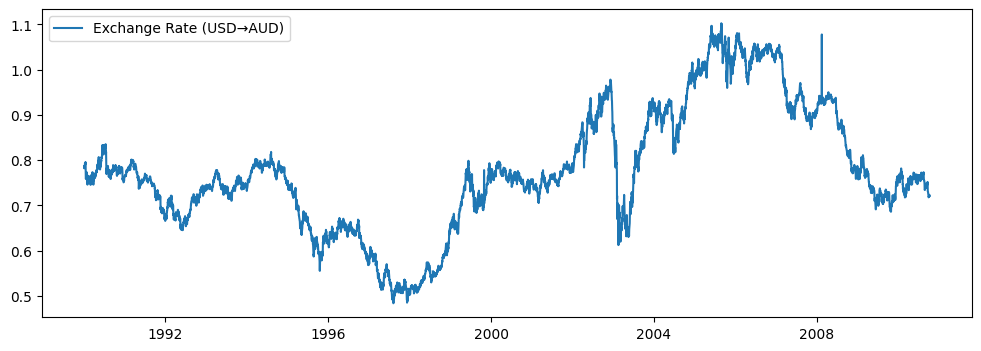

In [4]:
# Plot
plt.figure(figsize=(12,4))
plt.plot(ts, label="Exchange Rate (USD→AUD)")
plt.legend()
plt.show()

In [5]:
# Augmented Dickey-Fuller test
adf_result = adfuller(ts.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -1.6649941807381528
p-value: 0.4492327353597901


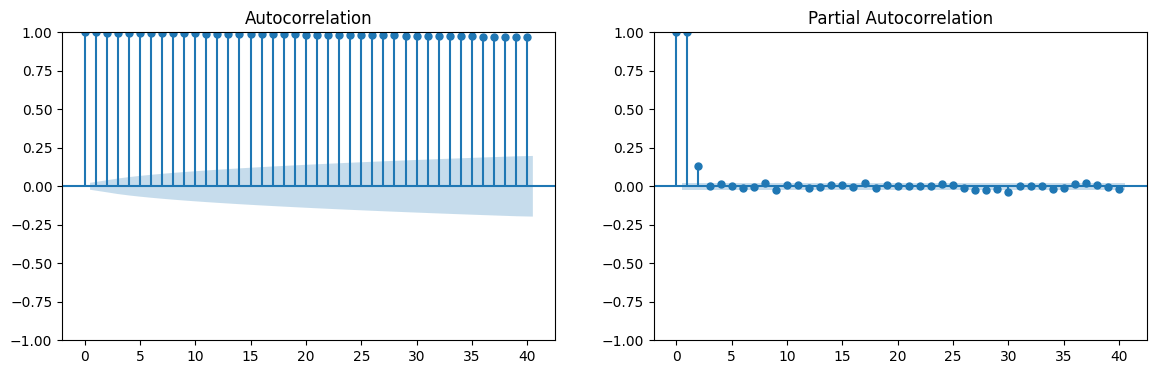

In [6]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
plot_acf(ts.dropna(), ax=ax[0], lags=40)
plot_pacf(ts.dropna(), ax=ax[1], lags=40)
plt.show()


In [7]:
# Example parameters (p=1,d=1,q=1) – tune based on ACF/PACF
model_arima = ARIMA(ts, order=(1,1,1))
arima_fit = model_arima.fit()
print(arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Fri, 29 Aug 2025   AIC                         -56102.322
Time:                        12:43:09   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

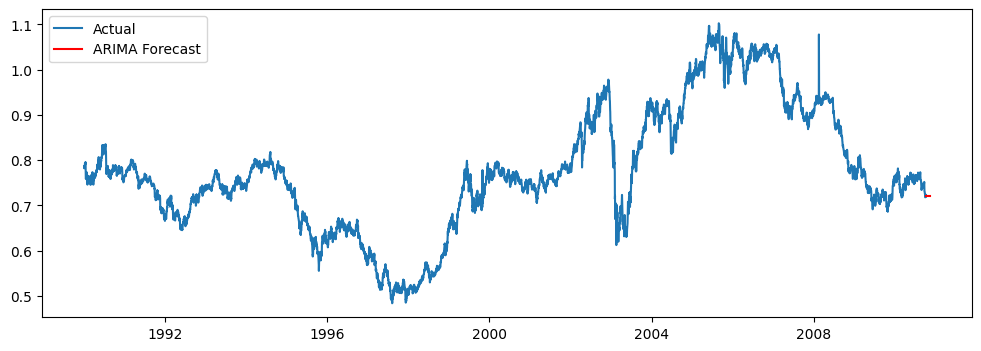

In [8]:
# Forecast next 30 days
forecast_arima = arima_fit.forecast(steps=30)

# Plot actual + forecast
plt.figure(figsize=(12,4))
plt.plot(ts, label="Actual")
plt.plot(forecast_arima.index, forecast_arima, label="ARIMA Forecast", color="red")
plt.legend()
plt.show()


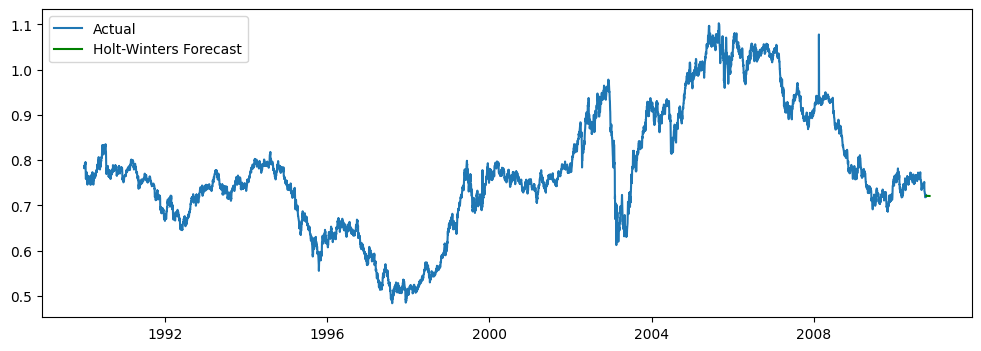

In [9]:
# Trend + Seasonality model
hw_model = ExponentialSmoothing(ts, trend="add", seasonal=None).fit()
forecast_hw = hw_model.forecast(30)

# Plot
plt.figure(figsize=(12,4))
plt.plot(ts, label="Actual")
plt.plot(forecast_hw.index, forecast_hw, label="Holt-Winters Forecast", color="green")
plt.legend()
plt.show()


In [10]:
# Split train-test (last 30 days for testing)
train, test = ts[:-30], ts[-30:]

# Fit ARIMA on train
arima_model = ARIMA(train, order=(1,1,1)).fit()
arima_pred = arima_model.forecast(steps=30)

# Fit Holt-Winters on train
hw_model = ExponentialSmoothing(train, trend="add", seasonal=None).fit()
hw_pred = hw_model.forecast(30)

# Metrics
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{model_name} → MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

evaluate(test, arima_pred, "ARIMA")
evaluate(test, hw_pred, "Holt-Winters")


ARIMA → MAE: 0.0135, RMSE: 0.0166, MAPE: 1.86%
Holt-Winters → MAE: 0.0134, RMSE: 0.0165, MAPE: 1.85%


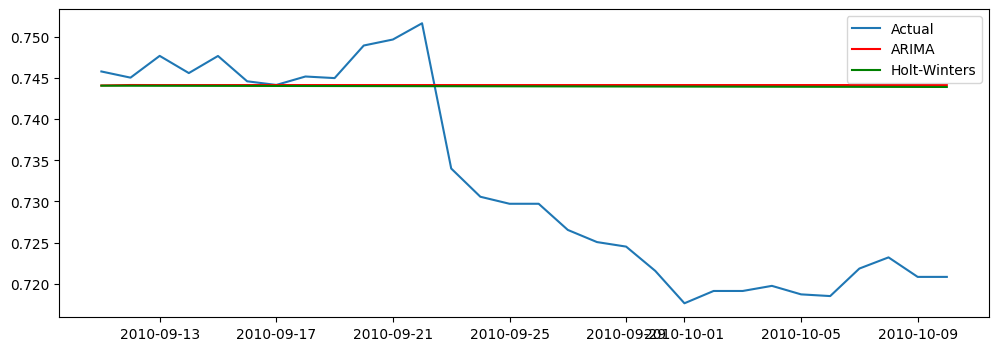

In [11]:

# Plot comparison
plt.figure(figsize=(12,4))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, arima_pred, label="ARIMA", color="red")
plt.plot(test.index, hw_pred, label="Holt-Winters", color="green")
plt.legend()
plt.show()
